**Validation of the runs in /Data Diversity Reproduction/**

*This file should eventually be replaced by a .py file.*

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from model import GPT2
import utils as u
from collect_data import LinRegData
from predictions import Ridge, oracle, DiscreteMMSE
from tqdm import tqdm
import yaml

assert torch.cuda.is_available()
device = 'cuda'

with open('../config.yaml', 'r') as f:
    config = yaml.safe_load(f)

In [10]:
step = 500000
run_ids = [
    "m5zm5bz9",
    "2dpt2ynr",
    "zya8efq4",
    "2fen9r0m",
    "agbondwy"
]

runs = {
    run_id: {
        "ckpt_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/{run_id}/checkpoints/epoch=0-step={step}.ckpt",
        "task_pool_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/{run_id}/task_pool.pt"
    } for run_id in run_ids
}

In [ ]:
# Validation for old training runs
# Incorrect weight decay, incorrect lr schedule
# step = 524288
# run_ids = [
#     # "lhuztt7a",
#     "0nk3a4b3",
#     "javn7bsd",
#     "ycr0ep5j",
#     "58es818e",
#     "79tldc2i",
#     "95tkac8y",
#     "hdsybk5p",
#     "iycztm7r",
# ]
# runs = {
#     run_id: {
#         "ckpt_path": f"/home/jovyan/data-diversity-reproduction/Data Diversity Reproduction/{run_id}/checkpoints/epoch=0-step={step}.ckpt",
#         "task_pool_path": f"/home/jovyan/data-diversity-reproduction/outputs/{run_id}_task_pool.pt"
#     } for run_id in run_ids
# }

# Correct weight decay, incorrect lr schedule
# step = 524288
# run_ids = [
#     "wupv4stc",
#     "nqccstbh"
# ]

In [11]:
for run_id, run in runs.items():
    task_pool = torch.load(run["task_pool_path"])
    run["task_pool_size"] = task_pool.shape[0]

run_ids = sorted(run_ids, key=lambda x: runs[x]["task_pool_size"])
task_pool_size = np.array([runs[run_id]["task_pool_size"] for run_id in run_ids])

In [14]:
model_names = ["Ridge", "DiscreteMMSE", "MOP", "Oracle"]

for run_id, run in runs.items():
    task_pool = torch.load(run["task_pool_path"])

    models = {
        "Ridge": Ridge(config['noise_scale']),
        "DiscreteMMSE": DiscreteMMSE(task_pool, config['noise_scale']),
        "MOP": GPT2.load_from_checkpoint(run["ckpt_path"], n_dims_in=config['dim']+1, n_positions=config['n_points'], config=config).eval().to(device),
        "Oracle": oracle
    }

    with torch.no_grad():
        linregdata = LinRegData(config, task_pool=task_pool)
        data_iterator = linregdata.batch_generator(config['n_validation_batches'])
        predictions = {k: [] for k in models}
        for i, batch in enumerate(data_iterator):
            for k, v in batch.items():
                batch[k] = v.to(device)
            for model_name, model in models.items():
                predictions[model_name].append(model(batch))
        for model_name in models:
            predictions[model_name] = torch.cat(predictions[model_name]).cpu()
        run["preds_pt"] = predictions

for run_id, run in runs.items():
    task_pool = torch.load(run["task_pool_path"])

    models = {
        "Ridge": Ridge(config['noise_scale']),
        "DiscreteMMSE": DiscreteMMSE(task_pool, config['noise_scale']),
        "MOP": GPT2.load_from_checkpoint(run["ckpt_path"], n_dims_in=config['dim']+1, n_positions=config['n_points'], config=config).eval().to(device),
        "Oracle": oracle
    }

    with torch.no_grad():
        linregdata = LinRegData(config, no_pool=True)
        data_iterator = linregdata.batch_generator(config['n_validation_batches'])
        predictions = {k: [] for k in models}
        for i, batch in enumerate(data_iterator):
            for k, v in batch.items():
                batch[k] = v.to(device)
            for model_name, model in models.items():
                predictions[model_name].append(model(batch))
        for model_name in models:
            predictions[model_name] = torch.cat(predictions[model_name]).cpu()
        run["preds_true"] = predictions

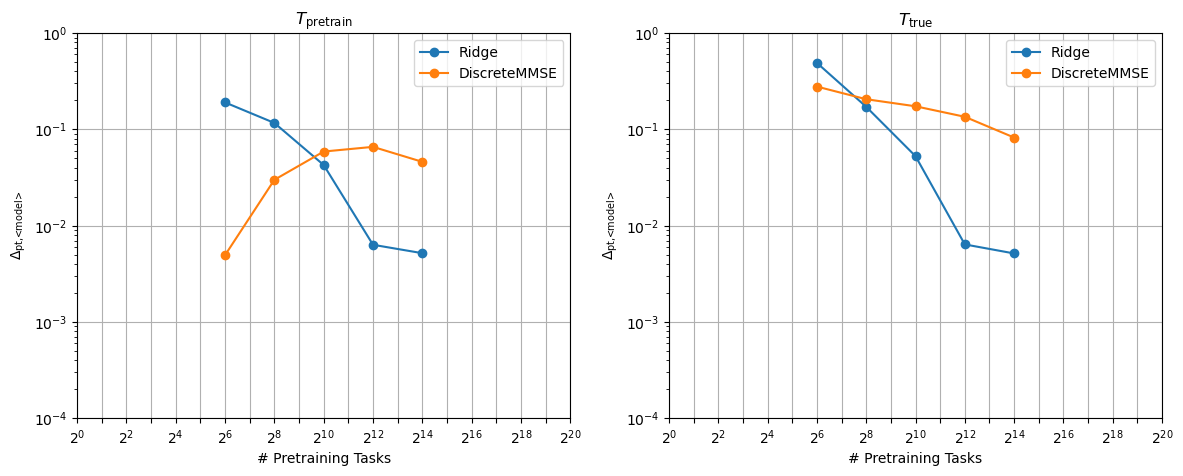

In [15]:
ridge_delta_pt = [
    torch.mean((runs[run_id]["preds_pt"]["MOP"] - runs[run_id]["preds_pt"]["Ridge"])**2).numpy()/config['dim'] for run_id in run_ids
]
dmmse_delta_pt = [
    torch.mean((runs[run_id]["preds_pt"]["MOP"] - runs[run_id]["preds_pt"]["DiscreteMMSE"])**2).numpy()/config['dim'] for run_id in run_ids
]
ridge_delta_true = [
    torch.mean((runs[run_id]["preds_true"]["MOP"] - runs[run_id]["preds_true"]["Ridge"])**2).numpy()/config['dim'] for run_id in run_ids
]
dmmse_delta_true = [
    torch.mean((runs[run_id]["preds_true"]["MOP"] - runs[run_id]["preds_true"]["DiscreteMMSE"])**2).numpy()/config['dim'] for run_id in run_ids
]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
ax[0].loglog(task_pool_size, ridge_delta_pt, marker='o', label='Ridge')
ax[0].loglog(task_pool_size, dmmse_delta_pt, marker='o', label='DiscreteMMSE')
ax[0].set_title("$T_\\text{pretrain}$")

ax[1].loglog(task_pool_size, ridge_delta_true, marker='o', label='Ridge')
ax[1].loglog(task_pool_size, dmmse_delta_true, marker='o', label='DiscreteMMSE')
ax[1].set_title("$T_\\text{true}$")

for axis in ax:
    x_range = list(range(0,21))
    x = [2**x for x in x_range]
    axis.set_xticks(x, labels=[(f"$2^{{{x}}}$" if not x%2 else "") for x in x_range])
    axis.tick_params(axis='x', which='minor', bottom=False)
    axis.set_ylim([1e-4,1])
    axis.set_xlabel("# Pretraining Tasks")
    axis.set_ylabel("$\Delta_{\\text{pt,<model>}}$")
    axis.grid()
    axis.legend()
fig.show()

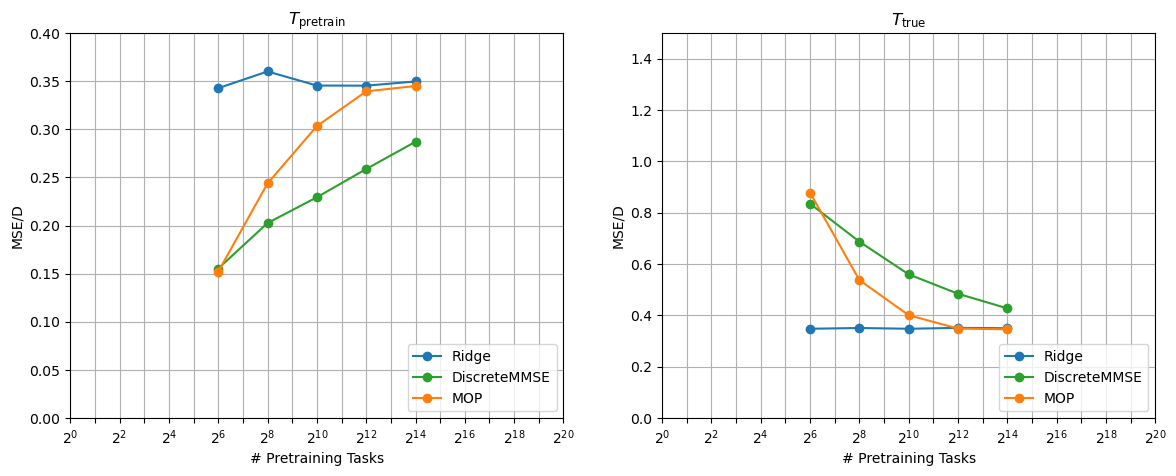

In [16]:
errors_pt = [[
    torch.mean((runs[run_id]["preds_pt"][model_name] - runs[run_id]["preds_pt"]["Oracle"])**2).numpy()/config['dim'] for run_id in run_ids
] for model_name in model_names if model_name != "Oracle"]

errors_true = [[
    torch.mean((runs[run_id]["preds_true"][model_name] - runs[run_id]["preds_true"]["Oracle"])**2).numpy()/config['dim'] for run_id in run_ids
] for model_name in model_names if model_name != "Oracle"]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
colors = ['1f77b4', '2ca02c', 'ff7f0e', 'd62728', '9467bd', '8c564b', 'e377c2', '7f7f7f', 'bcbd22', '17becf']
for j, errors in enumerate((errors_pt, errors_true)):
    for i, model_name in enumerate([model_name for model_name in model_names if model_name != "Oracle"]):
        ax[j].semilogx(task_pool_size, errors[i], label=model_name, marker='o', color="#"+colors[i])

ax[0].set_title("$T_\\text{pretrain}$")
ax[0].set_ylim([0,0.4])

ax[1].set_title("$T_\\text{true}$")
ax[1].set_ylim([0,1.5])

for axis in ax:
    x_range = list(range(0,21))
    x = [2**x for x in x_range]
    axis.set_xticks(x, labels=[(f"$2^{{{x}}}$" if not x%2 else "") for x in x_range])
    axis.tick_params(axis='x', which='minor', bottom=False)
    axis.set_xlabel("# Pretraining Tasks")
    axis.set_ylabel("MSE/D")
    axis.grid()
    axis.legend(loc='lower right')
fig.show()